In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# exponential model for salinity with  depth 
def salinity(h):
    s0 = 35   # surface salinity (ppt)
    sd = 34.5 # deep water saliity (ppt)
    H  = 150  # depth scale parm (typicallt 200) 
    s = s0 - (s0 -sd)*np.exp(-h/H)
    return s

In [3]:
# linear model for temp with depth  
def temp(h):
    t0 = 23 # surfcae temp (c)
    D = 150 # depth at which temp changes rapidly 
    return t0 - h/D
    

In [4]:
def sound_speed(h):
    rho = 1_025  # desnity of sea water (kg/m^3)
    p0 = 101_325 # atmospheric pressure (Pa)
    p = p0 + rho*9.81*h # pressure 
    p = p/100_000
    
    t = temp(h) # ocean temp(c)
    s = salinity(h)
    
    c = 1449.2 + 4.6*t-0.055*(t**2) + 0.00029*(t**3) + (1.34-0.010*t)*(s -35)+0.016*p
    return c

In [5]:
h = np.linspace(0,1000,10001)
ss = sound_speed(h)

In [6]:
ss

array([1528.894642  , 1528.89348259, 1528.89232291, ..., 1512.55222064,
       1512.55035845, 1512.54849623])

Text(0, 0.5, 'height(m)')

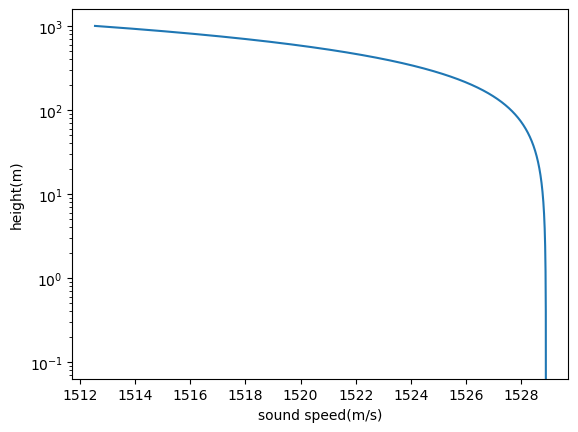

In [7]:
plt.plot(ss,h)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('sound speed(m/s)')
plt.ylabel('height(m)')

In [8]:
receiver_arr = np.arange(0,12.5*640,12.5) # add a number offset (x) source distance 
receiver_sep = np.arange(0,100*8,100) # there are 8 receiver arrays along(y)

In [9]:
receiver_net = np.meshgrid(receiver_arr,receiver_sep) # receivers on (x,y) grid 
xv,yv = receiver_net

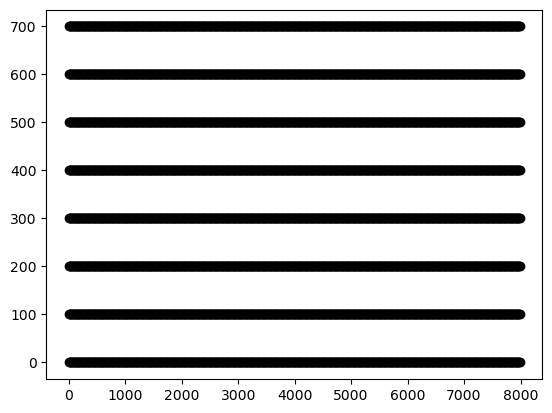

In [10]:
plt.plot(xv[:10], yv[:10], marker='o', color='k', linestyle='none')
plt.show()

In [11]:
receiver_depth = 5 

In [12]:
receiver_mesh = np.meshgrid(receiver_arr,receiver_sep,receiver_depth) # 3d receiver mesh 
xv,yv,zv = receiver_mesh    # each has shape of (8,640,1)

In [13]:
# the source coordinates (x,y,z)
source_coords = np.array([-100,-100,5])

In [14]:
# coordinates (x,y,z) of the receivers 
receiver_coords = np.concatenate((xv,yv,zv),axis=2) # shape(8,640,3)

In [15]:
# distance (direct) from source to receiver 
sep = np.sqrt(np.sum((receiver_coords - source_coords)**2,axis=2))
sep.shape

(8, 640)

In [18]:
# get the approx time for direct and water column (or sea bed) refclections 
# sep = distance from source to receiver
# depeth = depth at which reflection happens 
def approx_time(sep,depth):
    s_speed_max = 1530
    s_speed_min = 1512
    s_speed = (s_speed_max + s_speed_min)/2
    td = sep/s_speed 
    dr = 2*np.sqrt((sep/2)**2 + depth**2)
    tr = dr/s_speed 
    return td,tr

In [19]:
# get only the direct and sea bed reflection time 
td,tr = approx_time(sep[0],1000)

Text(0, 0.5, 'time(s)')

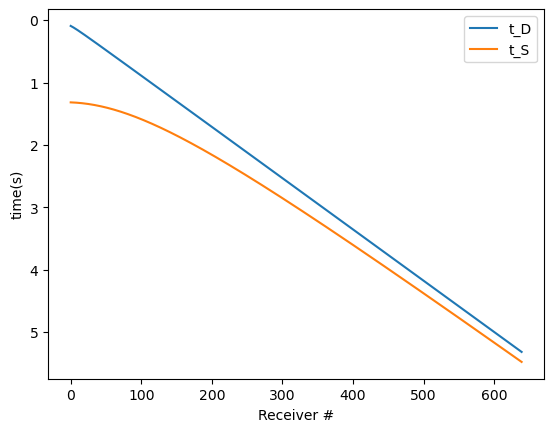

In [251]:
# plot time vs depth graph 
# note that the water column reflections occurs in between blue and orange
x = np.arange(0,640)
plt.plot(x,td,label='t_D')
plt.plot(x,tr,label='t_S')
ax = plt.gca()
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Receiver #')
plt.ylabel('time(s)')

In [180]:
# wave amplitude 
def u(x,t,t0=0,A0=2e2,s=1500,f= 100e3):
    t1=t+t0
    A = (A0/x)*np.exp(-15*t1)
    lamda = s/f
    omega = 2*np.pi*f 
    kapa = 2*np.pi/lamda 
    u = A*np.sin(kapa*x -omega*t1)
    u[t<t0] = 0
    return u

time = np.linspace(0,0.5,5000)
x_0  = sep[0][0]
s_0  = u(x_0,time)

In [177]:
delta_t = (tr-td)/10   # 1/10 of the time diference between D and S
print(delta_t[0])
delta_t0 = delta_t[0]  # get only the first receiver times 
fb = 200e3             # freq of the bubble waves

s_b0 = u(x_0,time,t0=delta_t0,f=fb)
s_b1 = u(x_0,time,t0= 2*delta_t0,f=fb)
s_b2 = u(x_0,time,t0= 4*delta_t0,f=fb)

0.12252284085069247


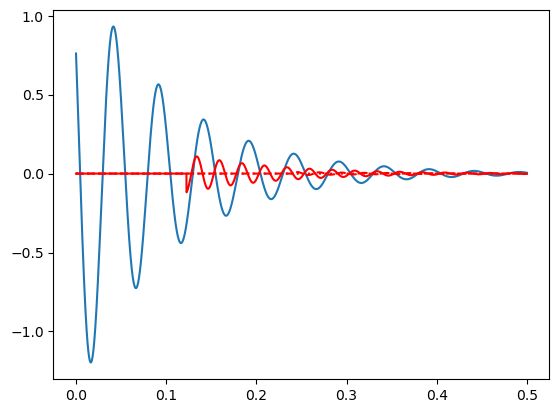

In [178]:
plt.plot(time,s_0)
plt.plot(time,s_b0,'r')
plt.plot(time,s_b1,'r--')
plt.plot(time,s_b2,'r:')

(-0.2, 0.2)

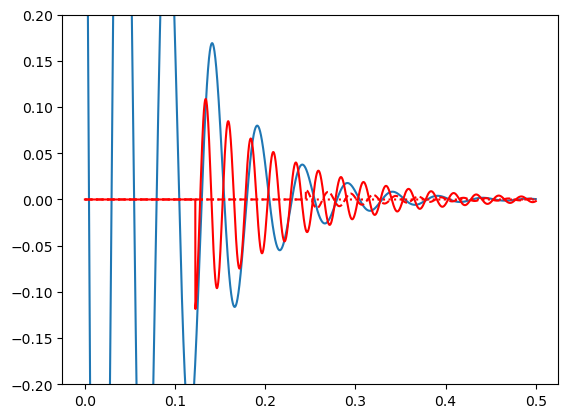

In [182]:
# zoom in to see bubble waves 
plt.plot(time,s_0)
plt.plot(time,s_b0,'r')
plt.plot(time,s_b1,'r--')
plt.plot(time,s_b2,'r:')
plt.ylim([-0.2,0.2])

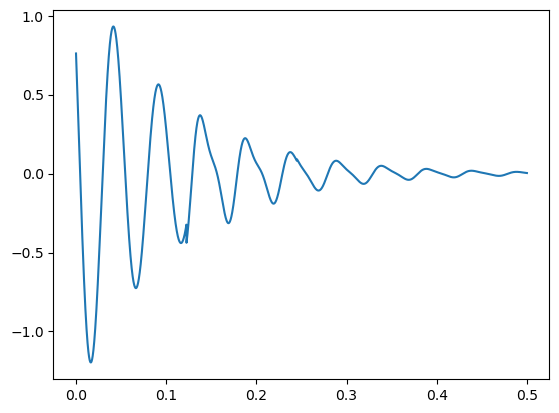

In [179]:
# bubble and source wave amplitude at 1st receiver 
A_t = s_0 + s_b0 + s_b1 + s_b2
plt.plot(time,A_t)

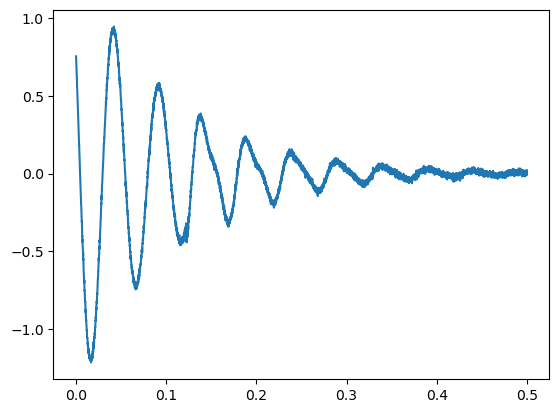

In [181]:
# adding a gassian noise (mean =0 sigma = 0.01) for BG 

A = A_t + np.random.normal(0,0.01,len(A_t))
plt.plot(time,A)

In [214]:
# de-noising from FFT 
n = len(time)
A_hat = np.fft.fft(A,n)
PSD = A_hat * np.conj(A_hat)/n

0.00010002000400080016


Text(0.5, 0, 'freq')

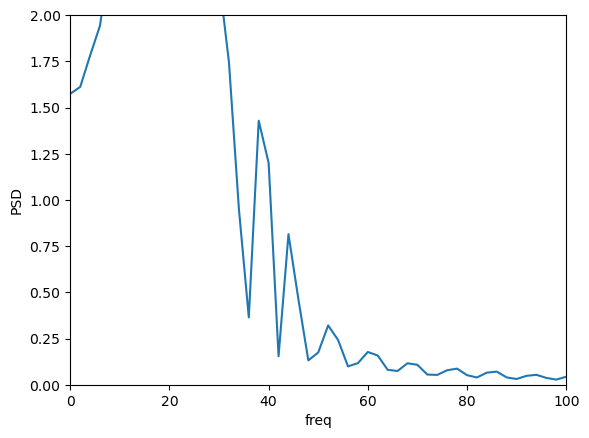

In [235]:
dt = time[1]-time[0]
print(dt)
freq = (1/(n*dt))*np.arange(n)
plt.plot(freq[:int(n/2)],PSD[:int(n/2)])
plt.xlim([0,100])
plt.ylim([0,2])
plt.ylabel('PSD')
plt.xlabel('freq')

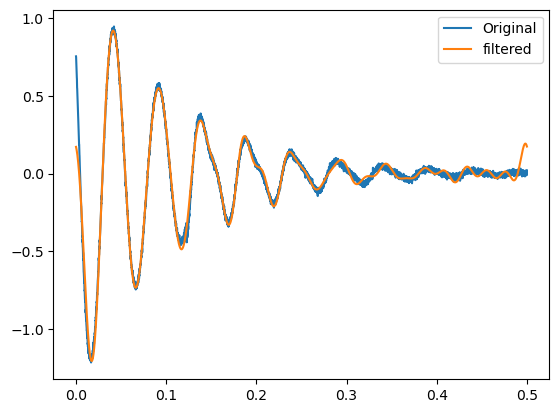

In [234]:
ind = PSD > 0.50
filt_Ahat = A_hat * ind
Afilt = np.fft.ifft(filt_Ahat)
plt.plot(time,A,label='Original')
plt.plot(time,Afilt,label='filtered')
plt.legend()

In [248]:
a = A
w = 100
b = np.ones(w)/w # average filter 
conv1d = np.convolve(a,b,mode='same')

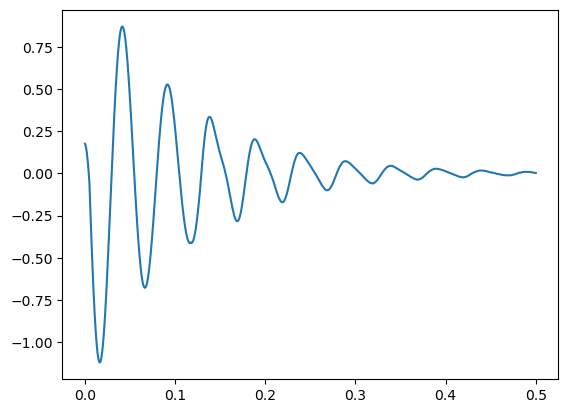

In [249]:
time.shape, conv1d.shape
plt.plot(time,conv1d)

In [ ]:
g = 